In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TRADES_PATH = "/content/historical_data.csv"
SENT_PATH   ="/content/fear_greed_index.csv"

In [3]:
# Output directories
ROOT = "/mnt/data/ds_outputs"
CSV_DIR = os.path.join(ROOT, "csv_files")
OUT_DIR = os.path.join(ROOT, "outputs")
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

In [4]:
# 1) Load files

df_trades = pd.read_csv(TRADES_PATH)
df_sent   = pd.read_csv(SENT_PATH)

In [5]:
# 2) Inspect column names (print and save for reproducibility)

print("Trades columns:", list(df_trades.columns))
print("Sentiment columns:", list(df_sent.columns))
pd.Series(df_trades.columns).to_csv(os.path.join(CSV_DIR, "trades_columns_list.csv"), index=False)

Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


In [7]:
# 3) Standardize names (lowercase & strip)

df_trades.columns = [c.strip() for c in df_trades.columns]
df_sent.columns = [c.strip() for c in df_sent.columns]

In [8]:
# 4) Identify best candidates for core columns with safe fallbacks

def pick_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

In [9]:
# Candidate names (adjusted for observed file)

col_account = pick_column(df_trades, ["Account", "account", "account_id"])
col_coin    = pick_column(df_trades, ["Coin", "coin", "symbol", "Symbol"])
col_price   = pick_column(df_trades, ["Execution Price", "Execution_Price", "price", "ExecutionPrice"])
col_size_tokens = pick_column(df_trades, ["Size Tokens", "Size_Tokens", "size_tokens", "size"])
col_size_usd    = pick_column(df_trades, ["Size USD", "Size_USD", "size_usd", "SizeUSD"])
col_side    = pick_column(df_trades, ["Side", "side"])
col_timestamp = pick_column(df_trades, ["Timestamp", "Timestamp IST", "timestamp", "time"])
col_pnl     = pick_column(df_trades, ["closedPnL", "ClosedPnL", "PnL", "Profit", "profit", "closed PnL"])
col_leverage= pick_column(df_trades, ["leverage", "Leverage", "lev", "margin_leverage"])

print("Mapped columns:")
print("account:", col_account)
print("coin:", col_coin)
print("price:", col_price)
print("size_tokens:", col_size_tokens)
print("size_usd:", col_size_usd)
print("timestamp:", col_timestamp)
print("pnl:", col_pnl)
print("leverage:", col_leverage)

Mapped columns:
account: Account
coin: Coin
price: Execution Price
size_tokens: Size Tokens
size_usd: Size USD
timestamp: Timestamp
pnl: None
leverage: None


In [10]:
# 5) Parse timestamp robustly

if col_timestamp:
    # try to detect numeric epoch (ms)
    sample = df_trades[col_timestamp].dropna().iloc[0]
    if isinstance(sample, (int, float, np.integer, np.floating)) or (isinstance(sample, str) and sample.isdigit()):
        # assume milliseconds if value is large (>1e11)
        val = float(sample)
        if val > 1e11:
            df_trades['time_parsed'] = pd.to_datetime(df_trades[col_timestamp], unit='ms', errors='coerce')
        else:
            # likely seconds
            df_trades['time_parsed'] = pd.to_datetime(df_trades[col_timestamp], unit='s', errors='coerce')
    else:
        df_trades['time_parsed'] = pd.to_datetime(df_trades[col_timestamp], errors='coerce')
else:
    df_trades['time_parsed'] = pd.NaT

df_trades['trade_date'] = df_trades['time_parsed'].dt.date

In [11]:
# 6) Convert numeric columns

if col_size_usd:
    df_trades['size_usd'] = pd.to_numeric(df_trades[col_size_usd], errors='coerce')
elif col_size_tokens:
    df_trades['size_tokens'] = pd.to_numeric(df_trades[col_size_tokens], errors='coerce')
    # If we don't have USD, we can use tokens as volume proxy
    df_trades['size_usd'] = df_trades['size_tokens'] * pd.to_numeric(df_trades[col_price], errors='coerce')

if col_price:
    df_trades['price'] = pd.to_numeric(df_trades[col_price], errors='coerce')

if col_pnl:
    df_trades['closedPnL'] = pd.to_numeric(df_trades[col_pnl], errors='coerce')

if col_leverage:
    df_trades['leverage'] = pd.to_numeric(df_trades[col_leverage], errors='coerce')

In [12]:
# abs size as volume measure

df_trades['abs_size_usd'] = df_trades['size_usd'].abs() if 'size_usd' in df_trades.columns else np.nan

In [13]:
# 7) Save cleaned copy for transparency

df_trades.to_csv(os.path.join(CSV_DIR, "trades_cleaned.csv"), index=False)
df_sent.to_csv(os.path.join(CSV_DIR, "feargreed_cleaned.csv"), index=False)

In [14]:
# 8) Compute daily aggregated metrics

agg_funcs = {
    'trades_count': ('trade_date', 'count'),
    'total_volume_usd': ('abs_size_usd', 'sum'),
}

In [15]:
# add leverage & pnl metrics if present

df_trades_for_agg = df_trades.copy()
if 'leverage' in df_trades_for_agg.columns:
    agg_funcs['avg_leverage'] = ('leverage', 'mean')
if 'closedPnL' in df_trades_for_agg.columns:
    agg_funcs['net_closedPnL'] = ('closedPnL', 'sum')
    agg_funcs['avg_closedPnL'] = ('closedPnL', 'mean')
    agg_funcs['win_rate'] = ('closedPnL', lambda x: (x>0).sum() / x.count() if x.count()>0 else np.nan)

In [16]:
# Build groupby with dynamic aggregator

grouped = df_trades_for_agg.groupby('trade_date').agg(**{
    k: pd.NamedAgg(column=v[0], aggfunc=v[1]) for k,v in agg_funcs.items()
}).reset_index()

In [17]:
# 9) Prepare sentiment DF: detect date column and classification column

sent_date_col = pick_column(df_sent, ["Date", "date", "day", "DateUTC"])
sent_class_col = pick_column(df_sent, ["Classification", "classification", "Sentiment", "SentimentLabel", "Label"])

if sent_date_col:
    df_sent['date_parsed'] = pd.to_datetime(df_sent[sent_date_col], errors='coerce').dt.date
else:
    # fallback: if first column looks like date
    df_sent['date_parsed'] = pd.to_datetime(df_sent.iloc[:,0], errors='coerce').dt.date

if sent_class_col:
    df_sent['Classification'] = df_sent[sent_class_col].astype(str)
else:
    # if only numeric value present, convert to Fear/Greed by median
    numeric_cols = df_sent.select_dtypes(include=[np.number]).columns
    if len(numeric_cols)>0:
        val = df_sent[numeric_cols[0]]
        med = val.median()
        df_sent['Classification'] = np.where(val >= med, 'Greed', 'Fear')
    else:
        df_sent['Classification'] = 'Unknown'

In [18]:
# 10) Merge daily grouped with sentiment by date

df_sent_small = df_sent[['date_parsed','Classification']].drop_duplicates().rename(columns={'date_parsed':'trade_date'})
# Ensure types align
grouped['trade_date'] = pd.to_datetime(grouped['trade_date']).dt.date
merged = pd.merge(grouped, df_sent_small, on='trade_date', how='left')


In [20]:
# 11) Aggregation by sentiment

# Initialize aggregation dictionary with always present columns
agg_dict_sentiment = {
    'trade_date': 'count',
    'trades_count': 'mean',
    'total_volume_usd': 'mean',
}

# Conditionally add avg_leverage if it exists in merged
if 'avg_leverage' in merged.columns:
    agg_dict_sentiment['avg_leverage'] = 'mean'

# Conditionally add net_closedPnL if it exists in merged
if 'net_closedPnL' in merged.columns:
    agg_dict_sentiment['net_closedPnL'] = 'mean'

summary_by_sentiment = merged.groupby('Classification').agg(agg_dict_sentiment).reset_index().rename(columns={'trade_date':'days_observed'})

In [21]:
# 12) Save outputs

grouped.to_csv(os.path.join(CSV_DIR, "daily_metrics.csv"), index=False)
merged.to_csv(os.path.join(CSV_DIR, "daily_metrics_with_sentiment.csv"), index=False)
summary_by_sentiment.to_csv(os.path.join(CSV_DIR, "summary_by_sentiment.csv"), index=False)


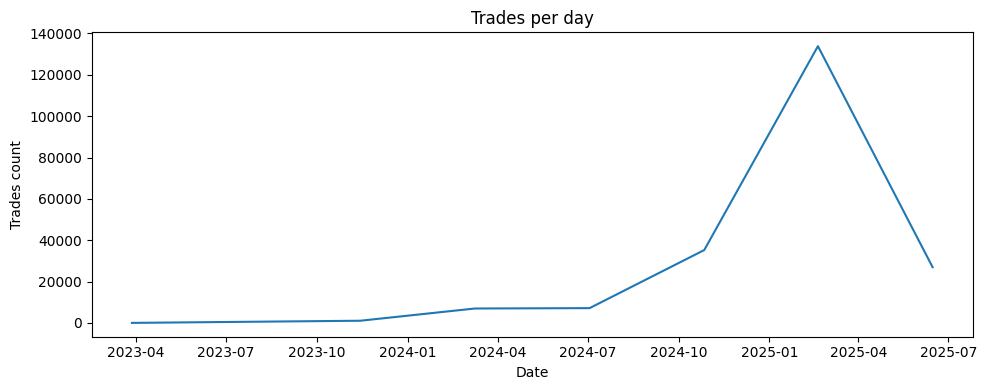

Saved CSV outputs to: /mnt/data/ds_outputs/csv_files
Saved plots to: /mnt/data/ds_outputs/outputs


In [22]:
# 13) Plots (matplotlib, single plot per figure; do not set colors specifically)
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(grouped['trade_date']), grouped['trades_count'])
plt.title("Trades per day")
plt.xlabel("Date")
plt.ylabel("Trades count")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "trades_per_day.png"))
plt.show()

if 'avg_leverage' in grouped.columns:
    plt.figure(figsize=(10,4))
    plt.plot(pd.to_datetime(grouped['trade_date']), grouped['avg_leverage'])
    plt.title("Average leverage per day")
    plt.xlabel("Date")
    plt.ylabel("Avg leverage")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "avg_leverage_per_day.png"))
    plt.show()

if 'net_closedPnL' in grouped.columns:
    plt.figure(figsize=(6,4))
    by_sent = merged.groupby('Classification')['net_closedPnL'].mean().reset_index()
    plt.bar(by_sent['Classification'], by_sent['net_closedPnL'])
    plt.title("Average daily net PnL by sentiment")
    plt.xlabel("Sentiment")
    plt.ylabel("Avg daily net PnL")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "avg_daily_netpnl_by_sentiment.png"))
    plt.show()

print("Saved CSV outputs to:", CSV_DIR)
print("Saved plots to:", OUT_DIR)